In [1]:
# Copyright 2023 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
!pip install --upgrade https://github.com/google-deepmind/nuclease-design.git


In [3]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from nuclease_design import utils
from nuclease_design import plotting
from nuclease_design import constants



# Constants

In [4]:
RANDOM_SEED = 0
DEFAULT_NUM_BOOTSTRAPS = 1000
RANDOM_STATE = np.random.RandomState(RANDOM_SEED)

In [5]:
DATA_DIR = constants.DATA_DIR

# Helper fns

In [6]:
def parse_activity_df_from_xml(activity_path):
  with utils.open_file(activity_path, 'rb', DATA_DIR) as f:
    tree = ET.parse(f)
    root = tree.getroot()

  well_dfs = []
  for sections in root.iter('PlateSection'):
      if (sections.attrib['Name'] != 'Plate1'):
        raise ValueError(f'Unexpected Plate {sections.attrib["Name"]}')
      for well in sections.iter('Well'):
          fluorescence = pd.Series(well.find('RawData').text.split(), dtype=float)
          time = pd.Series(well.find('TimeData').text.split(), dtype=float) / 60  # seconds to minutes
          well = well.get('Name')
          well_dfs.append(pd.DataFrame({'well': well, 'fluorescence': fluorescence, 'time': time}))
  return pd.concat(well_dfs, ignore_index=True)


In [7]:
# The number of points used here is to guarantee that we are measuring
# initial velocity in the linear regime of the reaction
# See https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4692135/ "Properties and mechanisms of enzyme action"
# for details
def add_initial_velocity(df, num_points=10):
  df = df.sort_values(by=['time'], ascending=True)
  x = df['time'][:num_points]
  y = df['fluorescence'][:num_points]

  result = stats.linregress(x, y, alternative='two-sided')

  slope_stderr = result.stderr
  slope = result.slope
  return pd.Series({'initial_velocity': slope, 'initial_velocity_stderr': slope_stderr, 'intercept': result.intercept})

# The wildtype is a particularly slow reaction, so we have many more points in
# the linear regime.
def add_initial_velocity_wrapper(df):
  if df.genotype.unique().item() == 'wild type':
    return add_initial_velocity(df, num_points=100)
  else:
    return add_initial_velocity(df)

def parametric_resample_row(row, random_state, n_bootstraps):
  mean = row['initial_velocity']
  stdev = row['initial_velocity_stderr']
  return random_state.normal(loc=mean, scale=stdev, size=n_bootstraps)

def get_bootstrapped_initial_velocity_df(df, random_state, n_bootstraps=DEFAULT_NUM_BOOTSTRAPS):
  return df.apply(parametric_resample_row, axis=1, random_state=random_state, n_bootstraps=n_bootstraps)


# Read in plate data

In [8]:
with utils.open_file(constants.PLATE_GENOTYPES_PATH, 'r', DATA_DIR) as f:
  genotypes_df = pd.read_csv(f)

In [9]:
platemap = {
    'O403':  ['A1', 'A2', 'A3', 'A4'],
    'O1757': ['C1', 'C2', 'C3', 'C4'],
    'O2360': ['E1', 'E2', 'E3', 'E4'],
    'O3188': ['G1', 'G2', 'G3', 'G4'],
    'O3459': ['I1', 'I2', 'I3', 'I4'],
    'O3512': ['K1', 'K2', 'K3', 'K4'],
    'O3513': ['M1', 'M2', 'M3', 'M4'],
    'O4060': ['O1', 'O2', 'O3', 'O4'],
}

well_to_strain = {}
for strain, wells in platemap.items():
  for well in wells:
    well_to_strain[well] = strain

well_to_concentration = {}
for row in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'M', 'O']:
  for concentration, column in zip([100, 50, 25, 12.5], ['1', '2', '3', '4']):
    well_to_concentration[''.join([row, column])] = concentration

In [10]:
df = parse_activity_df_from_xml(constants.TIME_SERIES_ACTIVITY_XML_PATH)
df['strain'] = df['well'].apply(well_to_strain.get)
df.dropna(subset=['strain'], inplace=True)
df = df[df['strain'] != 'O403']  # Removing WT assessed in a different background strain
df = df.merge(genotypes_df, how='left', on='strain')
df['concentration'] = df['well'].apply(well_to_concentration.get)

# Compute enzyme reaction rate

## Example of fitting reaction trajectory in linear regime

In [ ]:
slope = add_initial_velocity(df[df.well == 'K1'])['initial_velocity']
stderr = add_initial_velocity(df[df.well == 'K1'])['initial_velocity_stderr']
intercept = add_initial_velocity(df[df.well == 'K1'])['intercept']

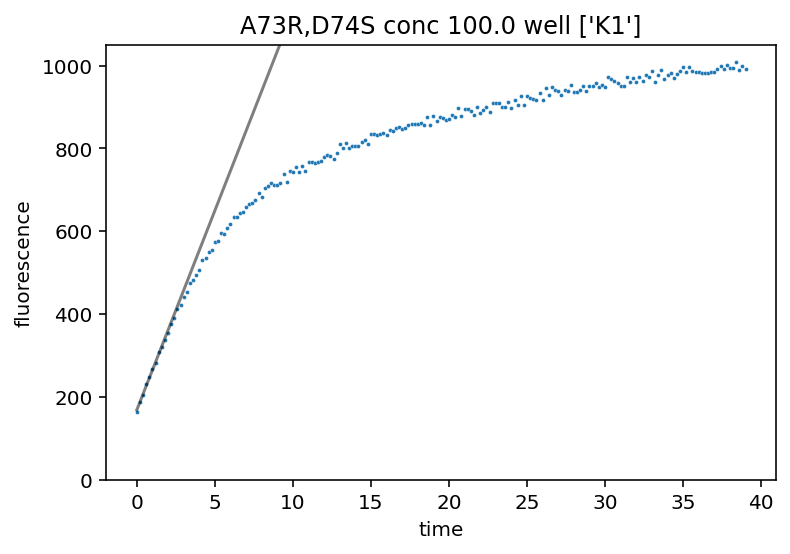

In [12]:
plotdf = df[(df['well'] == 'K1')]
sns.scatterplot(data=plotdf, x='time', y='fluorescence', s=4)
plt.ylim(bottom=0)
plt.plot(plotdf.time, intercept + slope * plotdf.time, 'black', alpha=0.5, label='initial velocity fit')
plt.title(f'{plotdf.genotype.iloc[0]} conc {plotdf.concentration.iloc[0]} well {plotdf["well"].unique()}')
plt.show()

## Add bootstrapped estimates of the rate

In [13]:
initial_velocity_df = df.groupby(['strain', 'genotype', 'concentration'], group_keys=True).apply(add_initial_velocity_wrapper).reset_index()
initial_velocity_df['initial_velocity_resampled'] = get_bootstrapped_initial_velocity_df(initial_velocity_df, RANDOM_STATE)
bootstrapped_initial_velocity_df = initial_velocity_df.explode('initial_velocity_resampled')

In [14]:
bootstrapped_initial_velocity_df.head()

,strain,genotype,concentration,initial_velocity,initial_velocity_stderr,intercept,initial_velocity_resampled
0,O1757,wild type,12.5,1.003808,0.025534,127.776027,1.048852
0,O1757,wild type,12.5,1.003808,0.025534,127.776027,1.014026
0,O1757,wild type,12.5,1.003808,0.025534,127.776027,1.028799
0,O1757,wild type,12.5,1.003808,0.025534,127.776027,1.061027
0,O1757,wild type,12.5,1.003808,0.025534,127.776027,1.051494


# Purified Protein Plot

In [15]:
genotype_to_library = {
    'wild type': 'WT',
    'A73R': 'epPCR',
    'A73R,D74S': 'ML2',
    'A63P,A73R,D74H,I84Y': 'ML3',
    'A63S,D64S,A73R': 'DE3',
    'D64A,A73R': 'ML2B',  # Also ML2
    'A63S,A132P': 'DE3B', # Internal DE. (sorted from OB174)
}
genotype_order = ('wild type', 'A73R', 'A73R,D74S', 'A63S,D64S,A73R', 'A63P,A73R,D74H,I84Y')
library_order = tuple(genotype_to_library[genotype] for genotype in genotype_order)

custom_palette = (plotting.WT_COLOR, plotting.EPPCR_COLOR, plotting.ML2_COLOR, plotting.DE3_COLOR, plotting.ML3_COLOR)

In [16]:
# add fields
bootstrapped_initial_velocity_df['activity'] = bootstrapped_initial_velocity_df['initial_velocity_resampled']
bootstrapped_initial_velocity_df['library'] = bootstrapped_initial_velocity_df.genotype.apply(genotype_to_library.get)

# remove other genotypes
bootstrapped_initial_velocity_df = bootstrapped_initial_velocity_df[bootstrapped_initial_velocity_df.genotype.isin(genotype_order)]

In [17]:
bootstrapped_initial_velocity_df.genotype.unique()

array(['wild type', 'A73R', 'A73R,D74S', 'A63P,A73R,D74H,I84Y',
       'A63S,D64S,A73R'], dtype=object)

In [18]:
def get_activity_relative_to_wt(df):
  wt_activities = df[df.genotype == 'wild type']['activity'].sample(n=len(df.activity), replace=True)
  df['fold_change_activity'] = df['activity'] / wt_activities.values
  return df

In [19]:
normalized_df = bootstrapped_initial_velocity_df.groupby(by='concentration', group_keys=False).apply(get_activity_relative_to_wt)

Text(0.5, 0, '')

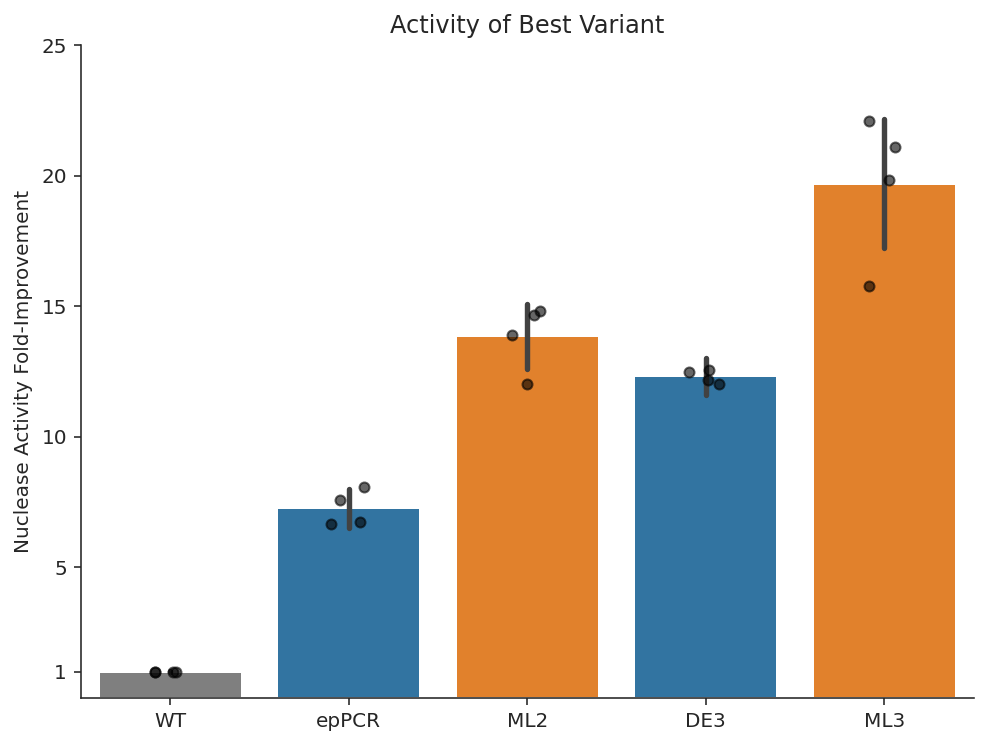

In [20]:
plt.figure(figsize=(8, 6))
ax = plotting.plot_purified_protein_activity(
    normalized_df,
    library_order=library_order,
    custom_palette=custom_palette,
)

points_df = (
    normalized_df.groupby(by=['genotype', 'concentration'])
    .agg({'fold_change_activity': 'mean'})
    .reset_index()
)
points_df['library'] = points_df.genotype.apply(genotype_to_library.get)
sns.stripplot(
    data=points_df,
    x='library',
    y='fold_change_activity',
    order=library_order,
    marker='o',
    facecolors='black',
    edgecolor='black',
    linewidth=1,
    alpha=0.6,
    ax=ax,
)
plt.xlabel('')

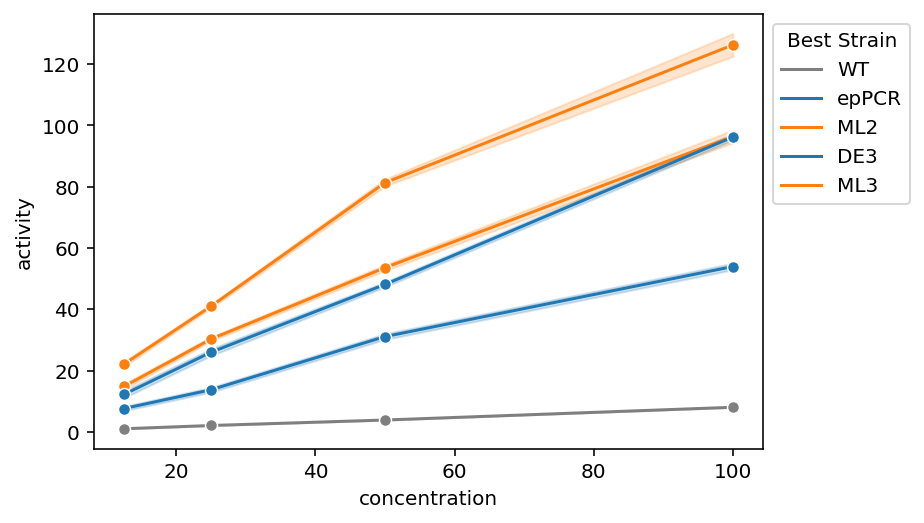

In [21]:
plt.figure(figsize=(6, 4))
ax = sns.lineplot(
    data=normalized_df,
    x='concentration',
    y='activity',
    hue='library',
    errorbar='sd',
    err_style='band',
    hue_order=library_order,
    marker='o',
    palette=custom_palette,
)
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
ax.get_legend().set_title('Best Strain')

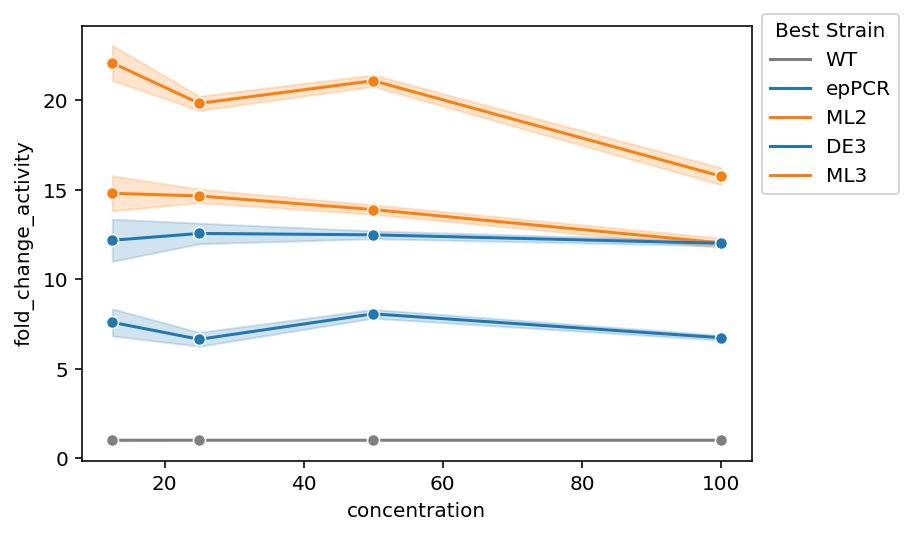

In [22]:
plt.figure(figsize=(6, 4))
ax = sns.lineplot(
    data=normalized_df,
    x='concentration',
    y='fold_change_activity',
    hue_order=library_order,
    errorbar='sd',
    err_style='band',
    hue='library',
    marker='o',
    palette=custom_palette,
)
plt.legend(bbox_to_anchor=[1.0, 1.05])
ax.get_legend().set_title('Best Strain')

# Permutation test

Test whether the fold_change_activity is greater for ML3 than DE3

In [23]:
initial_velocity_df = df.groupby(['strain', 'genotype', 'concentration'], group_keys=True).apply(add_initial_velocity_wrapper).reset_index()
initial_velocity_df['activity'] = initial_velocity_df['initial_velocity']
initial_velocity_df['library'] = initial_velocity_df.genotype.apply(genotype_to_library.get)
normalized_no_bootstrap_df = initial_velocity_df.groupby(by='concentration', group_keys=False).apply(get_activity_relative_to_wt)

In [24]:
normalized_no_bootstrap_df[normalized_no_bootstrap_df['library'].isin(['DE3', 'ML3', 'WT'])][['library', 'concentration', 'fold_change_activity']]

,library,concentration,fold_change_activity
0,WT,12.5,1.000000
1,WT,25.0,1.000000
2,WT,50.0,1.000000
3,WT,100.0,1.000000
20,ML3,12.5,22.020532
21,ML3,25.0,19.834930
22,ML3,50.0,21.092215
23,ML3,100.0,15.763609
24,DE3,12.5,12.184114
25,DE3,25.0,12.572068


In [25]:
de3_fold_changes = normalized_no_bootstrap_df[normalized_no_bootstrap_df['library'] == 'DE3']['fold_change_activity'].values

In [26]:
ml3_fold_changes = normalized_no_bootstrap_df[normalized_no_bootstrap_df['library'] == 'ML3']['fold_change_activity'].values

In [27]:
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

statistic(de3_fold_changes, ml3_fold_changes, axis=0)

-7.367076192596496

In [28]:
# Taken from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.permutation_test.html
# because our statistic is vectorized, we pass `vectorized=True`
# `n_resamples=np.inf` indicates that an exact test is to be performed
res = stats.permutation_test(
    (de3_fold_changes, ml3_fold_changes),
    statistic,
    vectorized=True,
    n_resamples=np.inf,
    alternative='less',
)

In [29]:
print(res.statistic)

-7.367076192596496


In [30]:
print(res.pvalue)

0.014285714285714285


In [31]:
stats.ttest_ind(de3_fold_changes, ml3_fold_changes)

Ttest_indResult(statistic=-5.31700848204106, pvalue=0.0018003144928412486)

## Account for uncertainty in slope estimation

We can do the same permutation test on our parametric bootstrap resamples of

  $$ \dfrac{\text{initial_velocity_A}} {\text{initial_velocity_WT}} $$

  where both the distribution of the numerator and denominator are modeled as Gaussian

<AxesSubplot: xlabel='fold_change_activity', ylabel='Count'>

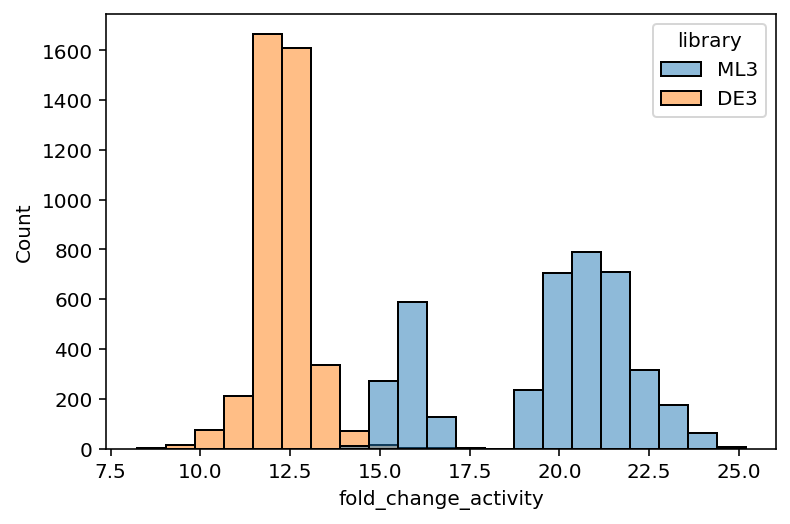

In [32]:
sns.histplot(data=normalized_df[normalized_df['library'].isin(['DE3', 'ML3'])], hue='library', x='fold_change_activity')

In [33]:
de3_fold_changes_resampled = normalized_df[normalized_df['library'] == 'DE3']['fold_change_activity'].values

In [34]:
ml3_fold_changes_resampled = normalized_df[normalized_df['library'] == 'ML3']['fold_change_activity'].values

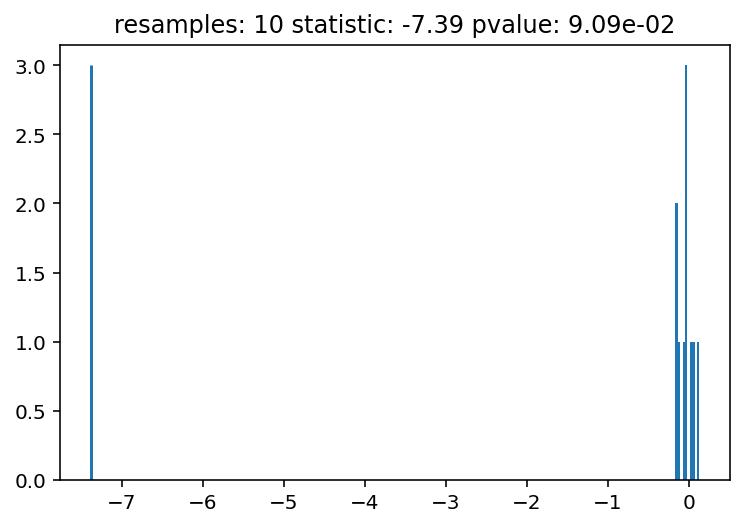

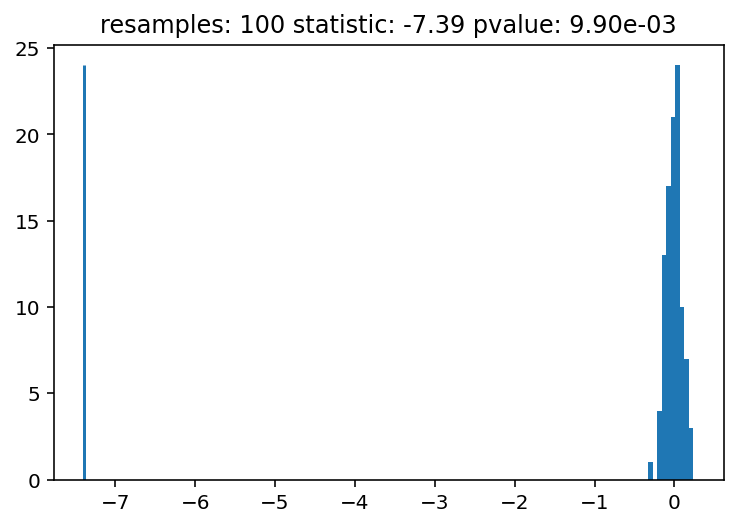

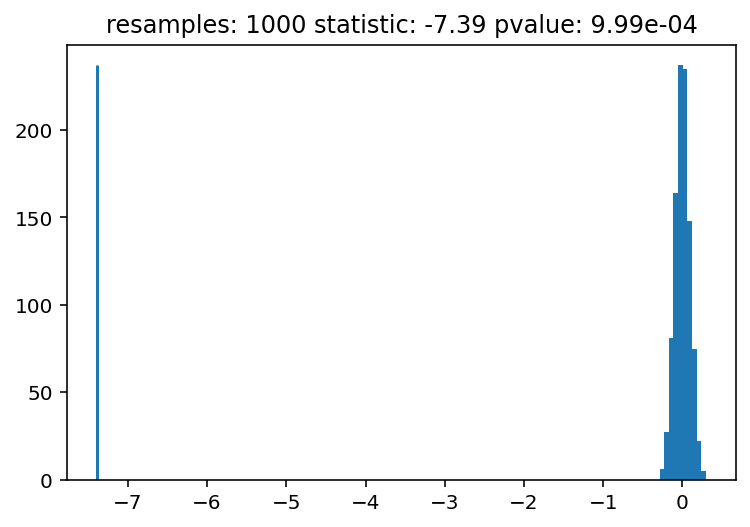

In [35]:
for n_resamples in [10, 100, 1000]:
  res = stats.permutation_test(
      (de3_fold_changes_resampled, ml3_fold_changes_resampled),
      statistic,
      vectorized=True,
      n_resamples=n_resamples,
      alternative='less',
      permutation_type='independent'
  )
  n, _, _ = plt.hist(res.null_distribution)
  plt.title(f'resamples: {n_resamples} statistic: {res.statistic:.2f} pvalue: {res.pvalue:0.2e}')
  plt.vlines(x=res.statistic, ymin=0, ymax=np.max(n))
  plt.show()

This dependence on the number of permutation test resamples is due to the test statistic being so significant that our numerical approximation of the p-value breaks down. In any case, this is clearly a significant result, and there's no reason to push any further on it

# Appendix

In [36]:
def make_initial_velocity_plot(df, genotype, concentration):
    genotype_df = df[
        (df['genotype'] == genotype) & (df['concentration'] == concentration)
    ]
    wtdf = df[
        (df['genotype'] == 'wild type') & (df['concentration'] == concentration)
    ]
    genotype_slope = add_initial_velocity_wrapper(genotype_df)['initial_velocity']
    genotype_intercept = add_initial_velocity_wrapper(genotype_df)['intercept']

    wt_slope = add_initial_velocity_wrapper(wtdf)['initial_velocity']
    wt_intercept = add_initial_velocity_wrapper(wtdf)['intercept']

    sns.scatterplot(
        data=pd.concat([genotype_df, wtdf]),
        x='time',
        y='fluorescence',
        s=8,
        alpha=0.5,
        hue='genotype',
        hue_order=['wild type', genotype],
    )
    plt.legend()

    wt_args = (wt_slope, wt_intercept, wtdf)
    genotype_args = (genotype_slope, genotype_intercept, genotype_df)
    for i, args in enumerate([wt_args, genotype_args]):
      slope, intercept, plotdf = args
      plt.plot(
          plotdf.time,
          intercept + slope * plotdf.time,
          alpha=0.2,)

    plt.ylim(bottom=0)
    plt.title(
        f'{genotype} conc {concentration} ng/mL well'
        f' {genotype_df["well"].unique()}'
    )
    plt.xlabel('time (min)')
    plt.xlim(left=0, right=40)
    # 2 minutes is what we used for slope estimation, 20 minutes is what we used for WT
    plt.xticks([0, 2, 10, 20, 30, 40])
    plt.show()


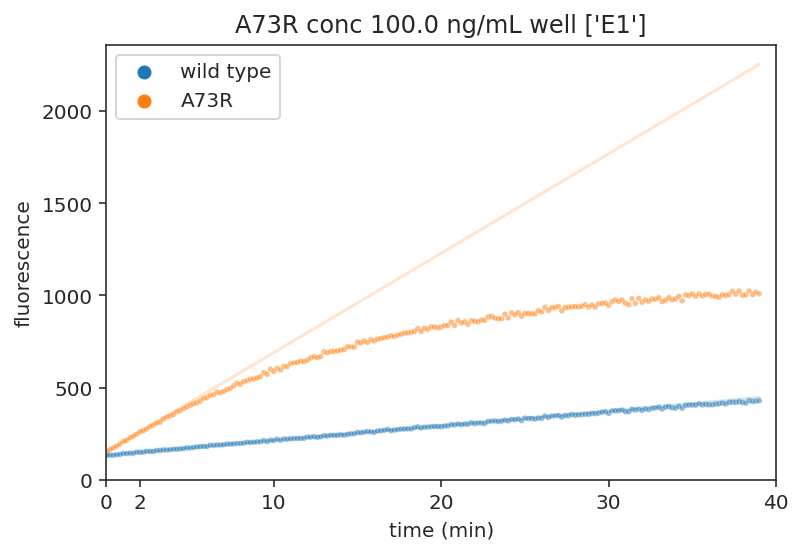

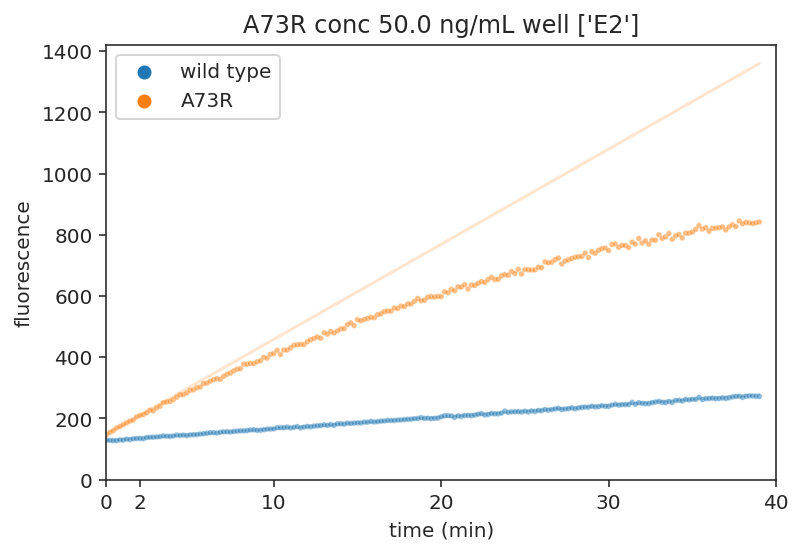

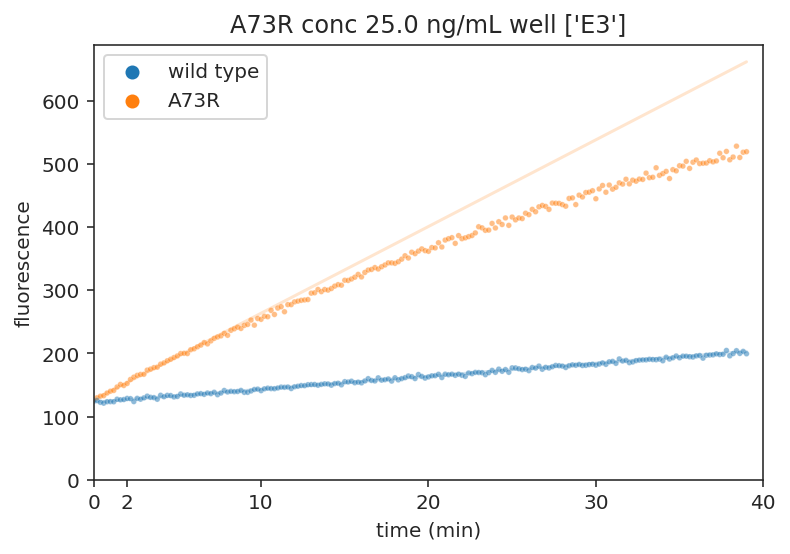

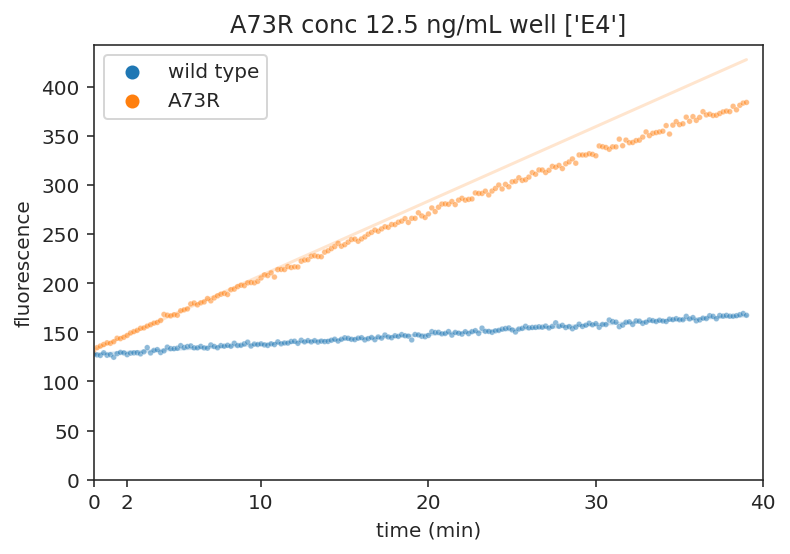

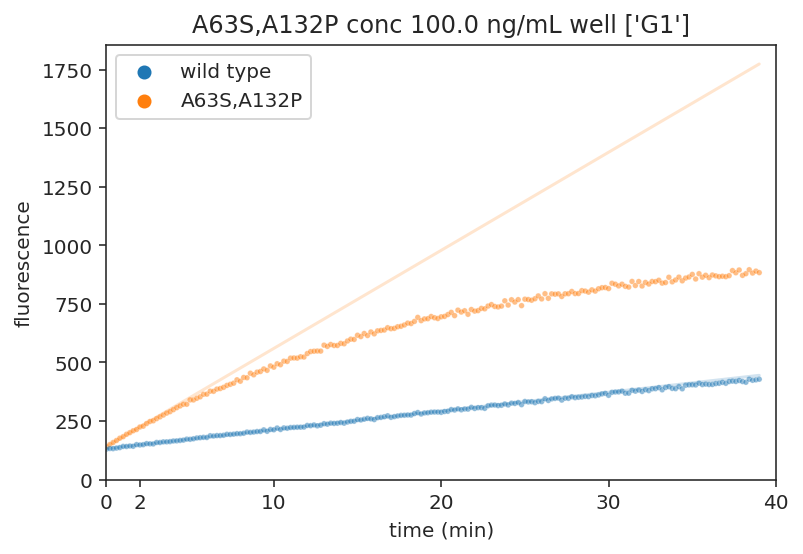

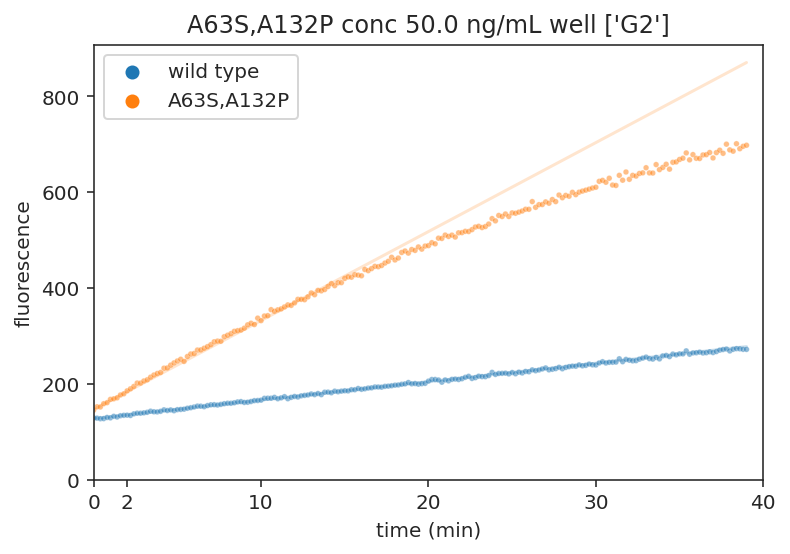

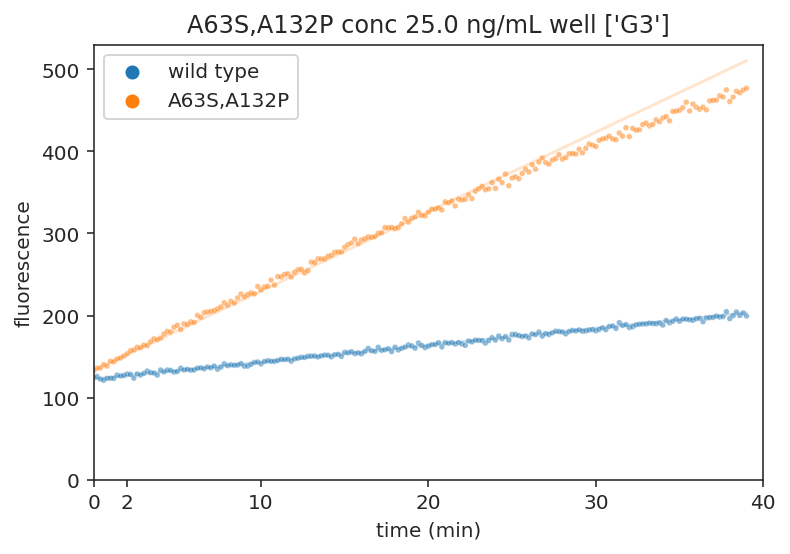

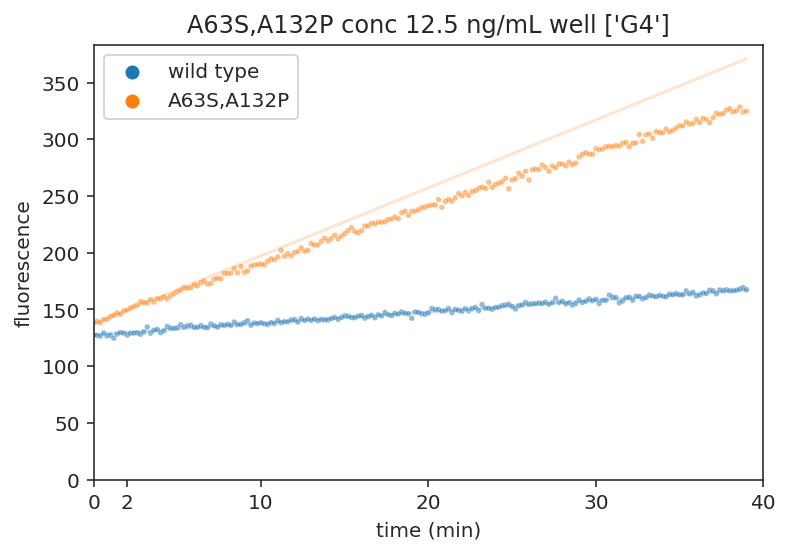

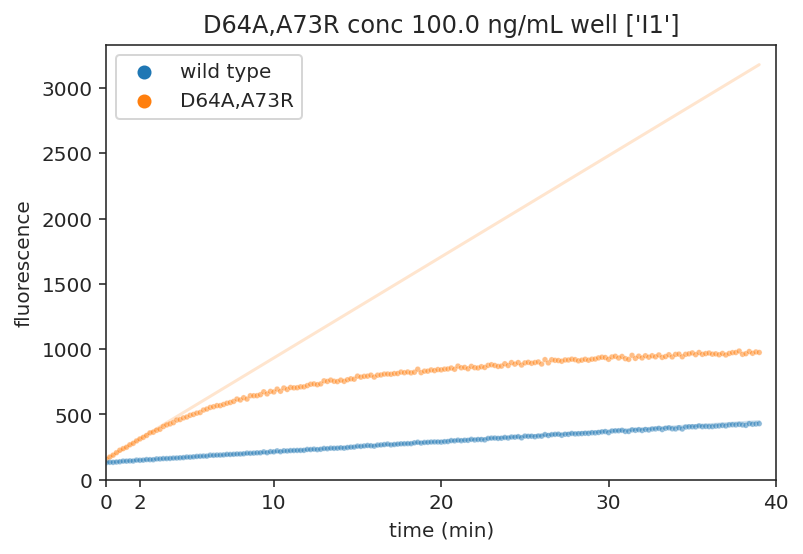

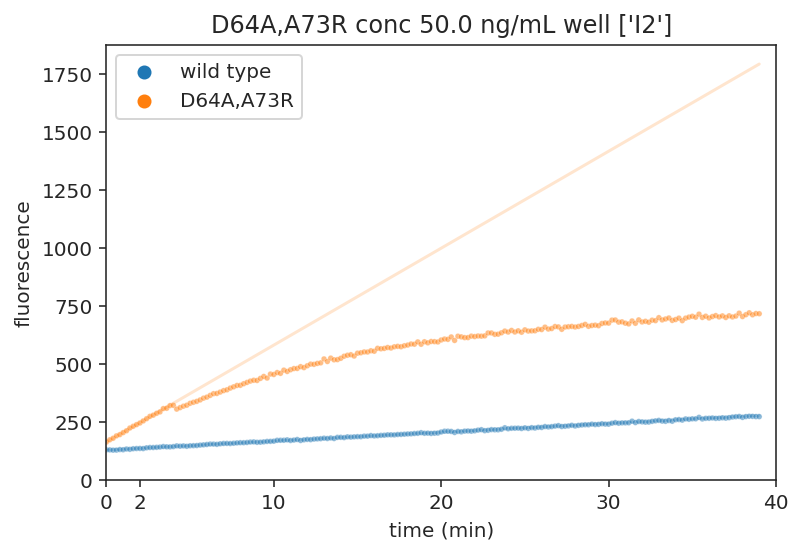

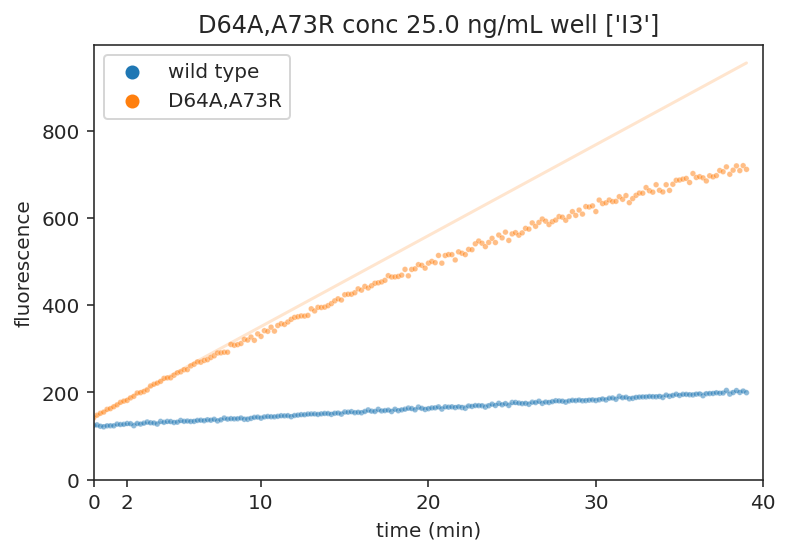

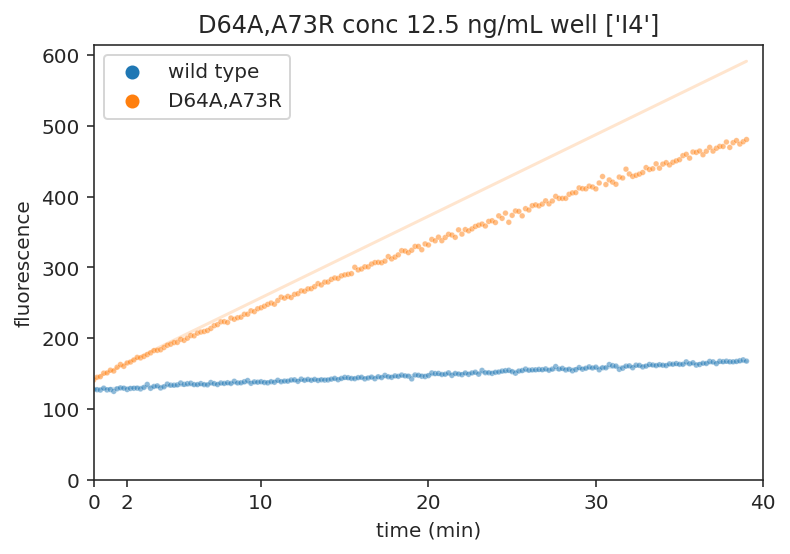

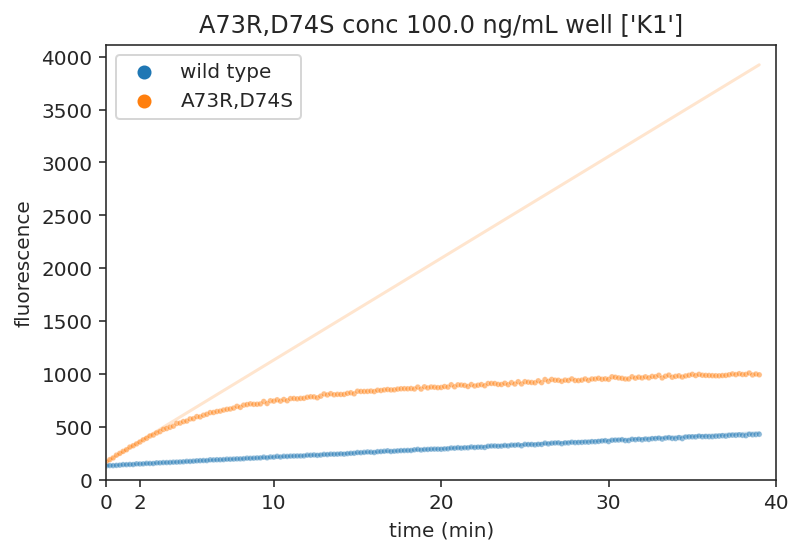

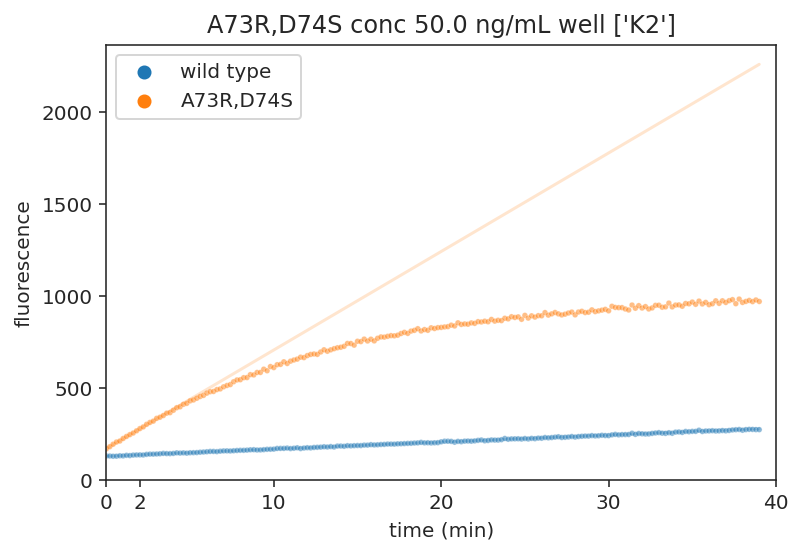

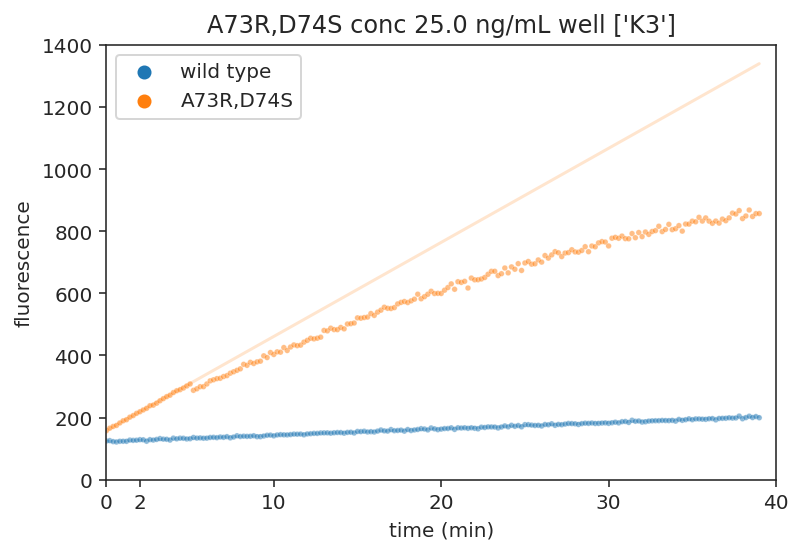

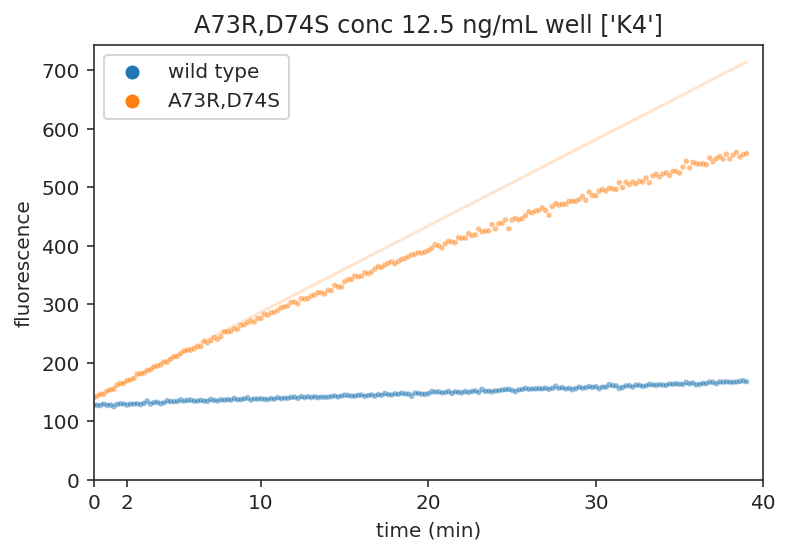

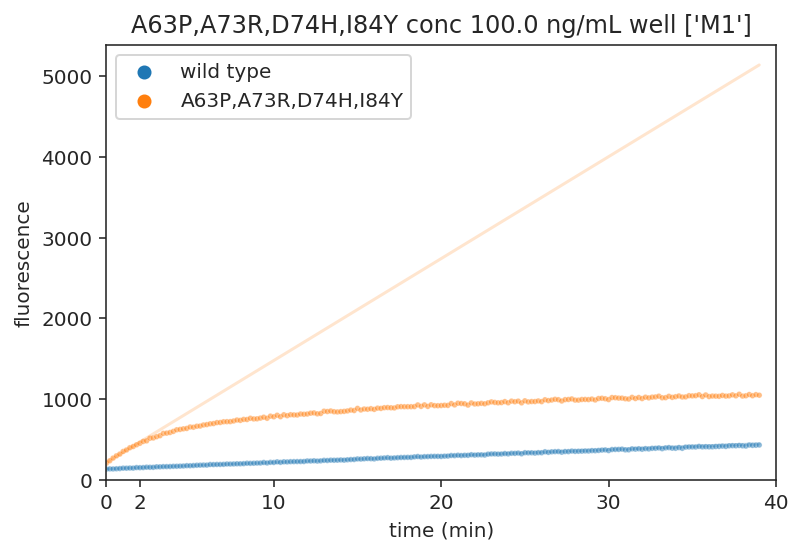

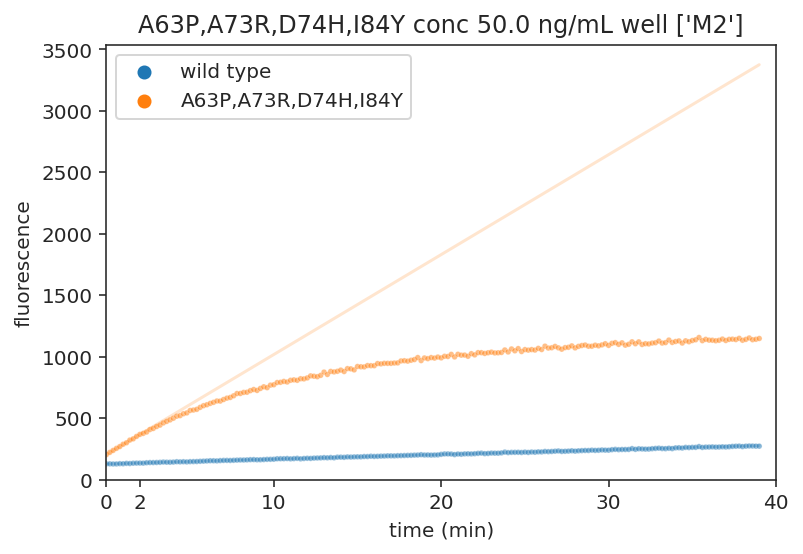

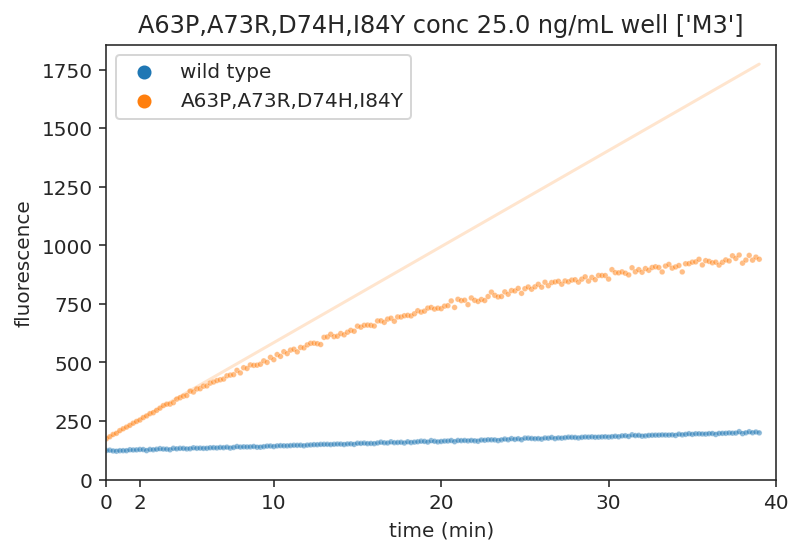

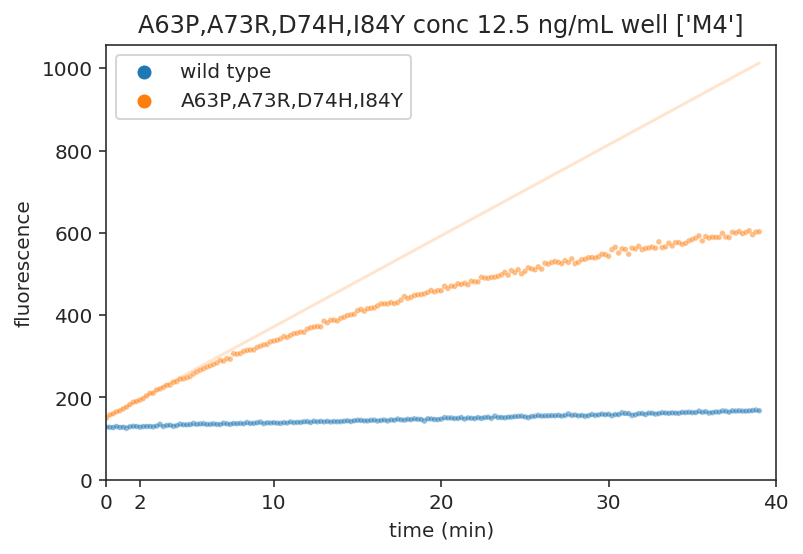

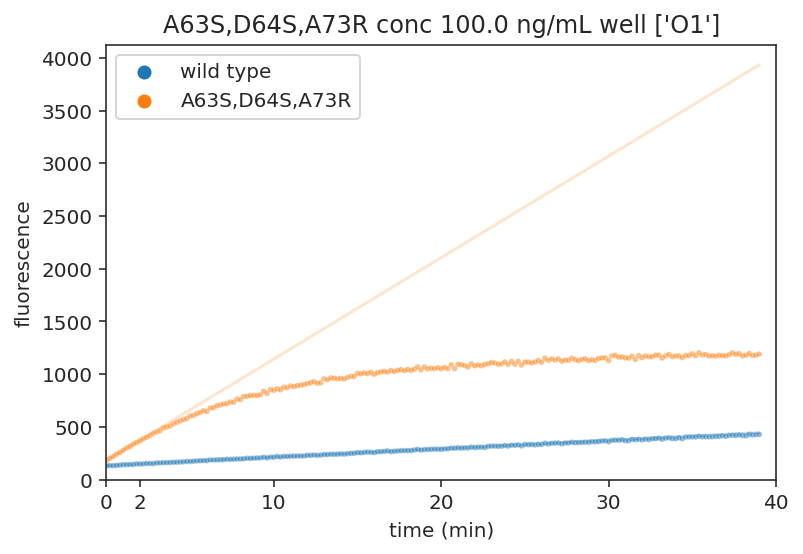

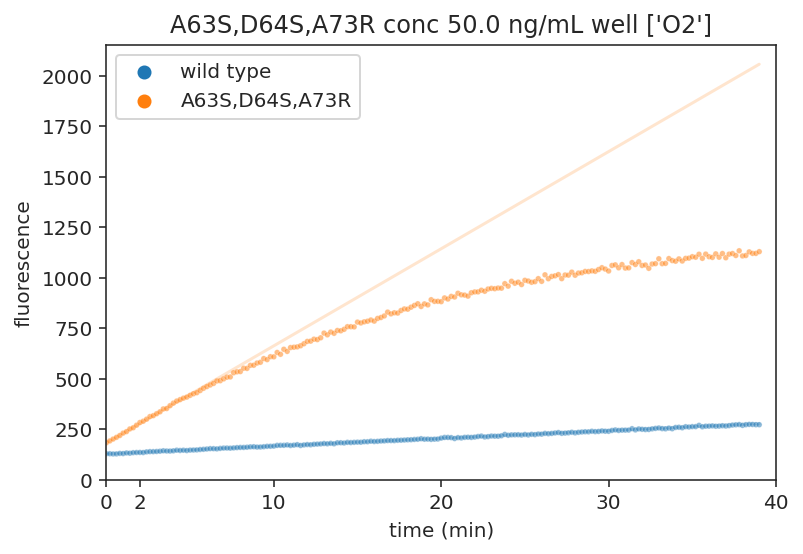

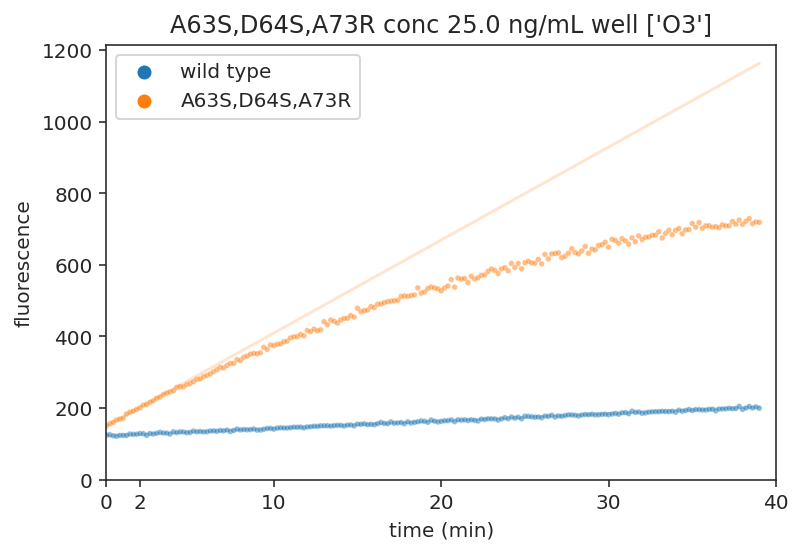

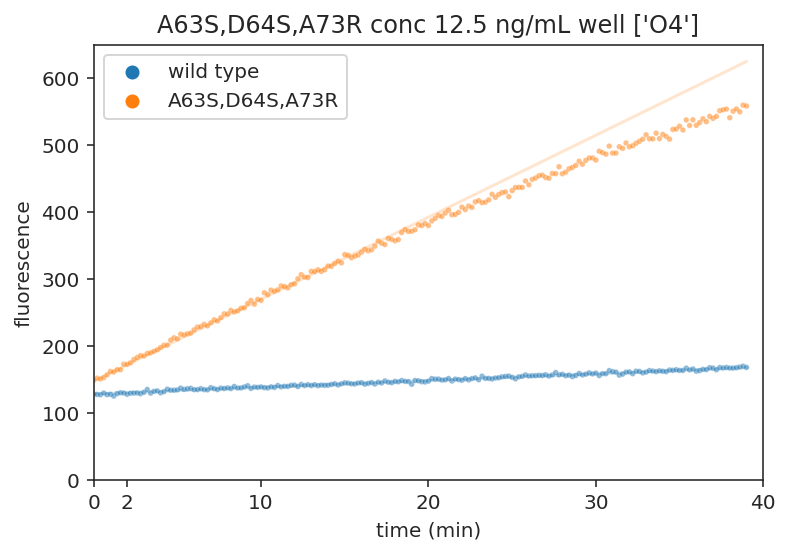

In [37]:
for genotype in df['genotype'].unique():
  for concentration in df['concentration'].unique():
    if genotype == 'wild type':
      continue
    with sns.axes_style('ticks'):
      make_initial_velocity_plot(df, genotype, concentration)

In [38]:
# Todo - add wt, DE3, ML3 fluorescence plots

# Appendix

## Provenance of top performers

In [39]:
all_data_df = utils.load_all_data()

In [40]:
def get_mutation_string_from_tuple(mutation_tuples):
    if len(mutation_tuples) == 0:
      return ''
    else:
      return ','.join([''.join([str(t) for t in mutation_tuple]) for mutation_tuple in mutation_tuples])

genotype_to_mutation_tuple = {
    'wild type': (),
    'A73R': (('A', 73, 'R')),
    'A73R,D74S': (('A', 73, 'R'), ('D', 74, 'S')),
    'A63P,A73R,D74H,I84Y': (('A', 63, 'P'), ('A', 73, 'R'), ('D', 74, 'H'), ('I', 84, 'Y')),
    'A63S,D64S,A73R': (('A', 63, 'S'), ('D', 64, 'S'), ('A', 73, 'R')),
    'D64A,A73R': (('D', 64, 'A'), ('A', 73, 'R')),
    'A63S,A132P': (('A', 63, 'S'), ('A', 132, 'P'))}


In [41]:
initial_velocity_df['mutations'] = initial_velocity_df.genotype.apply(genotype_to_mutation_tuple.get)

In [42]:
initial_velocity_df.merge(all_data_df, on='mutations', how='inner').groupby('mutations').aggregate('first')

,strain,genotype,concentration,initial_velocity,initial_velocity_stderr,intercept,activity,library,read_count_1_high_g1,read_count_1_input_g1,read_count_1_low_g1,read_count_2_high_g1,read_count_2_input_g1,read_count_2_low_g1,read_count_3_high_g1,read_count_3_input_g1,read_count_3_low_g1,read_count_1_input_reseq_g1,read_count_2_high_reseq_g1,read_count_2_input_reseq_g1,ef_1_high_g1,ef_2_high_g1,ef_3_high_g1,ef_2_high_reseq_g1,ef_1_low_g1,ef_2_low_g1,ef_3_low_g1,pvalue_gen_g1_ref_neg_control_2_high_reseq_right,activity_greater_than_neg_control,pvalue_gen_g1_ref_wt_2_high_reseq_right,activity_greater_than_wt,num_mutations,sublibrary_names,sequence,generation,read_count_1_input_deep_g2,read_count_1_input_g2,read_count_1_86_g2,read_count_1_97.5_g2,read_count_2_input_g2,read_count_2_93_g2,ef_1_86_g2,ef_2_93_g2,ef_1_97.5_g2,pvalue_gen_g2_ref_neg_control_1_86_right,pvalue_gen_g2_ref_wt_2_93_right,read_count_0_input_g3,read_count_1_59_g3,read_count_1_80_g3,read_count_2_95_g3,read_count_2_99_g3,ef_1_59_g3,ef_1_80_g3,ef_2_95_g3,ef_2_99_g3,pvalue_gen_g3_ref_neg_control_1_59_right,pvalue_gen_g3_ref_wt_1_80_right,pvalue_gen_g3_ref_a73r_1_80_right,activity_greater_than_a73r,read_count_0_input_g4,read_count_1_70_g4,read_count_2_90_g4,read_count_3_98_g4,read_count_4_99.5_g4,ef_1_70_g4,ef_2_90_g4,ef_3_98_g4,ef_4_99.5_g4,pvalue_gen_g4_ref_neg_control_1_70_right,pvalue_gen_g4_ref_wt_2_90_right,pvalue_gen_g4_ref_a73r_4_99.5_right,pvalue_gen_g4_ref_a73r_d74s_4_99.5_right,activity_greater_than_a73r_d74s,pvalue_gen_g4_ref_a63p_a73r_d74h_i84y_4_99.5_right,activity_greater_than_a63p_a73r_d74h_i84y
mutations,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
(),O1757,wild type,12.5,1.003808,0.025534,127.776027,1.003808,WT,104673.0,19361.0,60510.0,47566.0,14033.0,53702.0,348205.0,23619.0,109363.0,221350.0,444216.0,156279.0,3.920914,2.926922,5.024309,3.165749,2.826302,2.588309,2.818303,1.674893e-31,True,0.401998,False,0,"(g1_eppcr,)",MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASR...,g1,90180.0,25789.0,110109.0,22473.0,28540.0,14172.0,3.552858,0.883091,1.287185,8.904044e-19,5.725747e-01,50702.0,18384.0,393.0,277.0,86.0,1.239270,0.045545,0.025898,0.007079,5.456912e-12,4.976904e-01,0.992491,False,14504.0,6320.0,317.0,34.0,671.0,1.301032,0.047131,0.005162,0.148398,1.446546e-05,3.667602e-01,0.769120,0.908724,False,0.956709,False
"((A, 63, P), (A, 73, R), (D, 74, H), (I, 84, Y))",O3513,"A63P,A73R,D74H,I84Y",12.5,22.104394,0.787922,150.863745,22.104394,ML3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,True,4,"(g3_mbo_dnn_explore,)",MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASR...,g3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,387.0,116.0,136.0,1355.0,5531.0,1.024467,2.064905,16.597209,59.644412,6.083488e-09,2.159246e-15,0.803009,False,4552.0,2604.0,9169.0,52487.0,48782.0,1.708038,4.343676,25.389364,34.375719,2.964096e-08,6.556479e-67,0.018831,0.071005,False,0.511535,False
"((A, 73, R), (D, 74, S))",O3512,"A73R,D74S",12.5,14.740364,0.915919,139.125273,14.740364,ML2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,True,2,"(g2_mbo_dnn_explore,)",MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASR...,g2,372.0,17.0,250.0,735.0,26.0,447.0,2.808936,9.699032,14.659325,4.127771e-14,4.741095e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,14658.0,5997.0,18168.0,74218.0,75761.0,1.221570,2.672822,11.149024,16.579271,4.221568e-05,1.457530e-52,0.263834,0.494866,False,0.820638,False
"((D, 64, A), (A, 73, R))",O3459,"D64A,A73R",12.5,11.525152,0.961870,141.774564,11.525152,ML2B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,True,2,"(g2_mbo_dnn_explore,)",MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASR...,g2,256.0,38.0,209.0,929.0,41.0,472.0,2.909051,12.687211,22.953326,9.490210e-15,2.294374e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,208.0,135.0,245.0,1958.0,724.0,1.937891,2.540039,20.727727,11.165281,5.756593e-10